In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import ttest_ind

# Group comparison
in this chapter we are discussing how to compare groups of independent measurements.  As an example, we are going to look at a sample of 10th grade math scores from two different public U.S. high schools.  Thirty-one students from school 1 and 28 students from school 2 were randomly selected.  Both schools have a total enrollment of around 500 10th graders each, and both are in urban neighborhoods.

In [2]:
school1scores=np.array([52.11, 57.65, 66.44, 44.68, 40.57, 35.04, 50.71, 66.17, 39.43, 
46.17, 58.76, 47.97, 39.18, 64.63, 69.38, 32.38, 29.98, 59.32, 
43.04, 57.83, 46.07, 47.74, 48.66, 40.8, 66.32, 53.7, 52.42, 
71.38, 59.66, 47.52, 39.51])
school2scores=np.array([52.87, 50.03, 41.51, 37.42, 64.42, 45.44, 46.06, 46.37, 46.66, 
29.01, 35.69, 49.16, 55.9, 45.84, 35.44, 43.21, 48.36, 74.14, 
46.76, 36.97, 43.84, 43.24, 56.9, 47.64, 38.84, 42.96, 41.58, 
45.96])

(array([  1.,   4.,   3.,  11.,   4.,   2.,   1.,   1.,   0.,   1.]),
 array([ 29.01 ,  33.523,  38.036,  42.549,  47.062,  51.575,  56.088,
         60.601,  65.114,  69.627,  74.14 ]),
 <a list of 10 Patch objects>)

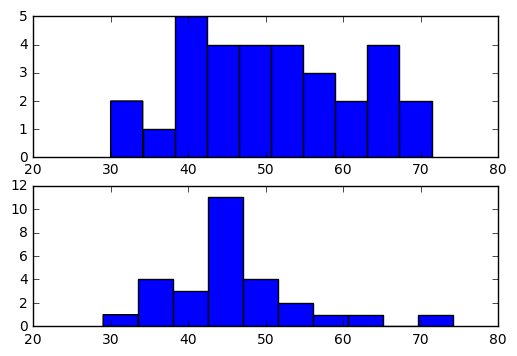

In [3]:
plt.figure()
plt.subplot(2,1,1)
plt.hist(school1scores)
plt.subplot(2,1,2)
plt.hist(school2scores)

{'boxes': [<matplotlib.lines.Line2D at 0x1112d8da0>,
 'caps': [<matplotlib.lines.Line2D at 0x1112e5860>,
 'fliers': [<matplotlib.lines.Line2D at 0x1112eba58>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1112eb240>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1112d8f60>,
  <matplotlib.lines.Line2D at 0x1112f6978>]}

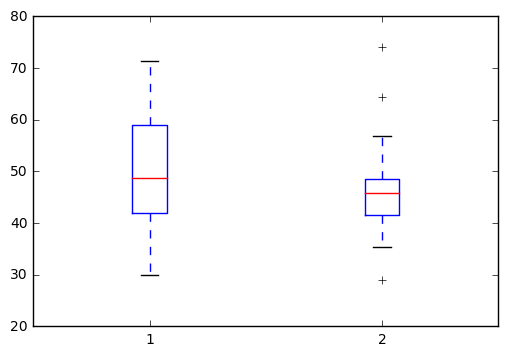

In [4]:
data=[school1scores,school2scores]
plt.figure()
plt.boxplot(data)

In [5]:
s1mean=school1scores.mean()
s1std=school1scores.std(ddof=1)
s2mean=school2scores.mean()
s2std=school2scores.std(ddof=1)
print("School 1 mean {}, std {}".format(s1mean,s1std))
print("School 2 mean {}, std {}".format(s2mean,s2std))

School 1 mean 50.81354838709678, std 11.250249641196737
School 2 mean 46.15071428571428, std 9.052143567940313


In [6]:
result=ttest_ind(school1scores,school2scores)
print(result)

Ttest_indResult(statistic=1.7418211969266815, pvalue=0.086934028254851275)


According to "standard" statistics the difference between the two schools seems not significant.  Let us see whether we can learn a little more by using a Bayesian approach.

We start by expressing the scores of the two schools as draws from two distributions:

$$Y_{i,1} = \mu + \delta + N(0,\sigma^{2})$$
$$Y_{i,2} = \mu -\delta + N(0,\sigma^{2})$$

here we assume that the standard deviation for both schools is the same.  We chose priors for these parameters to be
$$P(\mu,\delta,\sigma^{2}) = P(\mu)P(\delta)P(\sigma^{2})$$
$$P(\mu) = N(\mu_{0},\gamma_{0})$$
$$P(\delta) = N(\delta_{0},\tau_{0})$$
$$P(\sigma^{2}) = inverse-gamma(\nu_{0}/2,\nu_{0}\sigma_{0}/2)$$

As parameters we chose the following:

1) $\mu_0$ should be $50$ since the average test score nationwide has a mean of $50$.

2) a reasonable $\sigma_{0}=10^{2}=100$

3) $\gamma_{0}^{2}=25^{2}=625$ and $\nu_{0}=1$

4) $\delta_{0}=0$ and $\tau_{0}^{2}=25^{2}=625$

In [7]:
import pymc as pm

In [8]:
nu0=1.0
gamma0=25.0
mu0=50.0
sigma0=10.0
delta0=0.0
tau0=25.0

In [9]:
sigmaSquare=pm.InverseGamma('sigmaSquare',nu0/2.0,nu0*sigma0**2/2.0)
mu=pm.Normal('mu',mu=mu0,tau=1/gamma0**2)
delta=pm.Normal('delta',mu=delta0,tau=1/tau0**2)

In [10]:
s1=pm.Normal('s1',mu=mu+delta,tau=1/sigmaSquare,value=school1scores,observed=True)

In [11]:
s2=pm.Normal('s2',mu=mu-delta,tau=1/sigmaSquare,value=school2scores,observed=True)

In [12]:
m=pm.MCMC([sigmaSquare,mu,delta,s1,s2])

In [13]:
m.sample(iter=10000,burn=1000,thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.0 sec

Plotting delta
Plotting mu
Plotting sigmaSquare


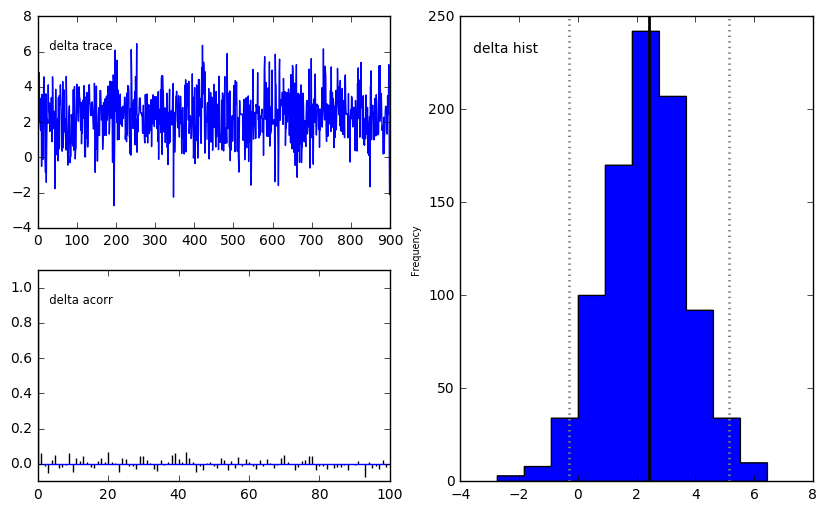

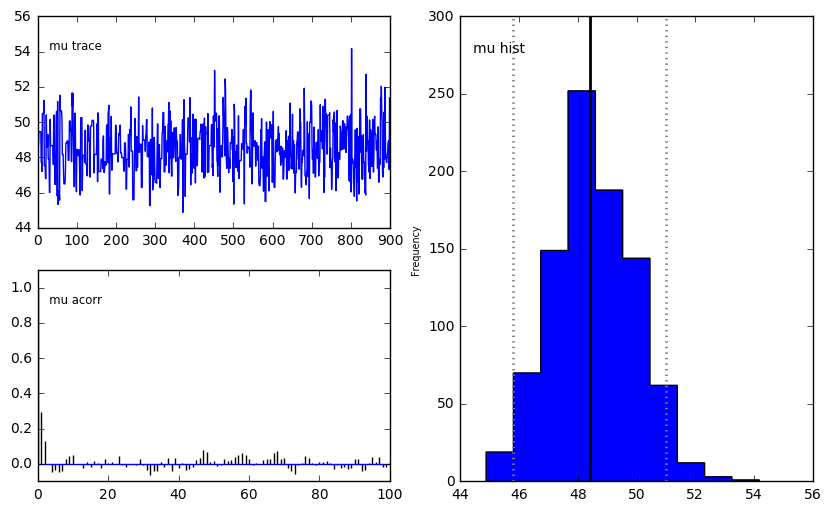

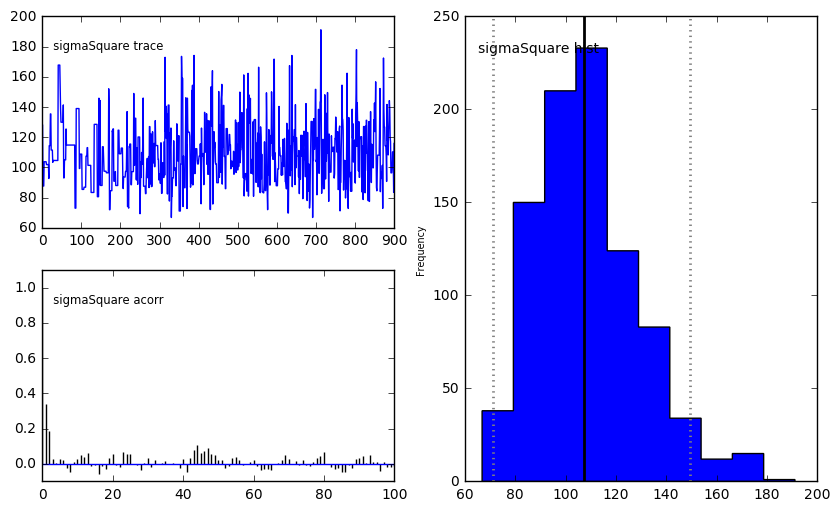

In [14]:
pm.Matplot.plot(m)

In [15]:
m.summary()


delta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	2.34             1.395            0.048            [-0.305  5.137]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.391           1.422           2.418          3.249         5.09
	

mu:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	48.504           1.392            0.061          [ 45.782  51.011]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	45.867           47.564          48.421         49.515        51.238
	

sigmaSquare:
 
	Mean             SD               MC Error        95% HPD interval
	------------------

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [20]:
# get the delta trace (sample) from the MCMC simulation
delta_trace=np.array(m.trace('delta')[:])

In [23]:
# calculate the probability that the difference between schools is greater than zero
delta_trace_greater_zero=delta_trace[delta_trace>0]
print(delta_trace_greater_zero.size/delta_trace.size)

0.9511111111111111
